In [1]:
%matplotlib inline

import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd
from forecast import forecast, stl, stldf, bind
from itertools import product
from dateutil.parser import parse
from datetime import date, timedelta
from rpy2.robjects import r, pandas2ri as pd2

sys.path.extend(['./forecast-master', './forecast-master/forecast'])
bind(pd.DataFrame, stldf)
bind(pd.Series, stl, forecast)

# Посмотрим на данные

se -  вид поисковая система ['search', 'yandex']

browser - браузеры ['chrome', 'firefox', 'msie', 'opera', 'yabrowser']

date - даты по дням 2014.01.01 - 2017.09.28

In [2]:
df = pd.read_csv('df0.csv')
se_names = df.se.unique()
browser_names = df.browser.unique()
df.head()

,date,se,browser,hits
0,2014-01-01,search,chrome,44778823.0
1,2014-01-01,yandex,chrome,16237589.0
2,2014-01-02,search,chrome,52448725.0
3,2014-01-02,yandex,chrome,18979110.0
4,2014-01-03,search,chrome,54640145.0


In [3]:
se_names

array(['search', 'yandex'], dtype=object)

In [4]:
browser_names

array(['chrome', 'firefox', 'msie', 'opera', 'yabrowser'], dtype=object)

In [5]:
DAY0, DAY_LAST = parse(df.date[0]), parse(df.date.iloc[-1])
DAY0, DAY_LAST

(datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2017, 9, 28, 0, 0))

# Обработка данных

## Посмотрим на браузеры

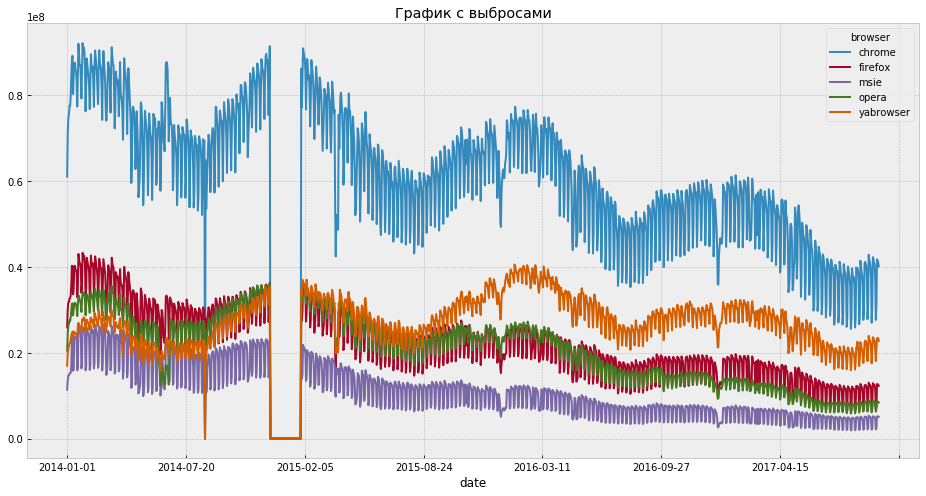

In [28]:
full_df.pivot_table(index='date', values='hits',columns='browser', aggfunc=sum).plot(title = 'График с выбросами')

Отчетливо видно, что график надо поправлять

## Недостающие 4 дня
Обработаем ситуацию, о которой упоменалось на паре: не хватает 4 дней, заполним их в соответсвие с предыдущим периодом.

Запомним эти 4 дня.

In [9]:
print("не хватает: ", - df.groupby(['se', 'browser']).size() - (DAY0 - DAY_LAST).days + 1)
miss_date = ['2014-12-28', '2014-12-29', '2014-12-30', '2014-12-31']

не хватает:  se      browser  
search  chrome       4
        firefox      4
        msie         4
        opera        4
        yabrowser    4
yandex  chrome       4
        firefox      4
        msie         4
        opera        4
        yabrowser    4
dtype: int64


In [10]:
full_df = df.copy()
for se, browser in product(se_names, browser_names):
    for date in miss_date:
        full_df.loc[full_df.shape[0]] = [date, se, browser, 0]

full_df = full_df.sort_values(['browser', 'date']).reset_index(drop=True)
print("не хватает: ", - full_df.groupby(['se', 'browser']).size() - (DAY0 - DAY_LAST).days + 1)

не хватает:  se      browser  
search  chrome       0
        firefox      0
        msie         0
        opera        0
        yabrowser    0
yandex  chrome       0
        firefox      0
        msie         0
        opera        0
        yabrowser    0
dtype: int64


# Выбросы
Заметим, что рядом с новым годом 2014 и 2015 года заметны аномальные точки. Возможно, люди и прада не пользуются интернетом, или же программа как-то не правильно обрабатывает начало года

Попробуем убрать выбросы и сравнить графики

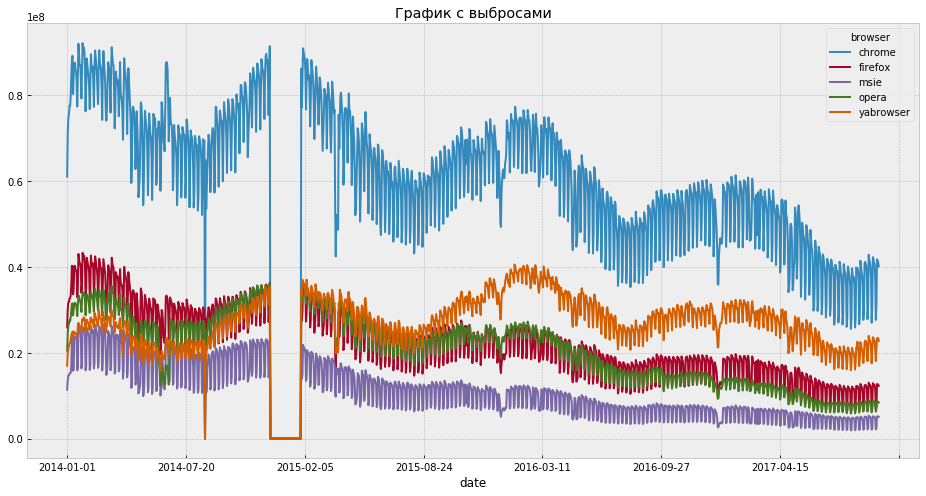

In [11]:
full_df.pivot_table(index='date', values='hits',columns='browser', aggfunc=sum).plot(title = 'График с выбросами')

Рассмотрим подробнее графи, там есть нулевые выбросы, например в августе 2014, и даже целый платы (8-26)

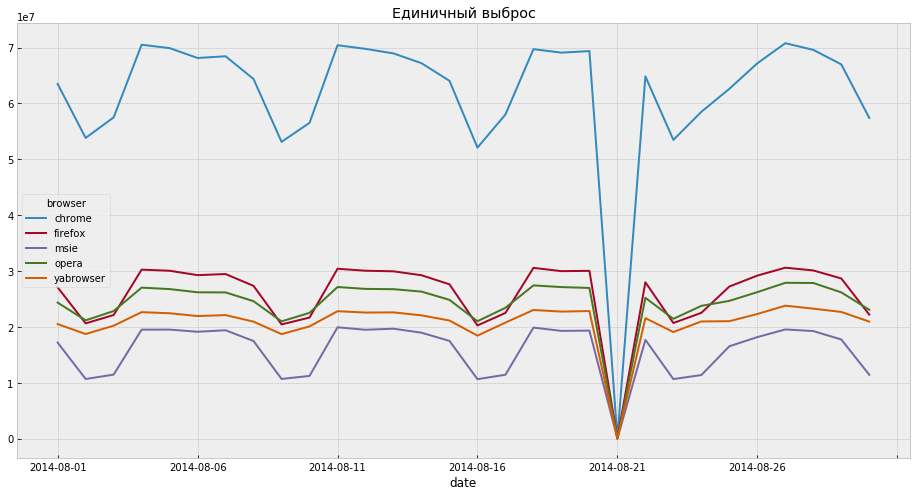

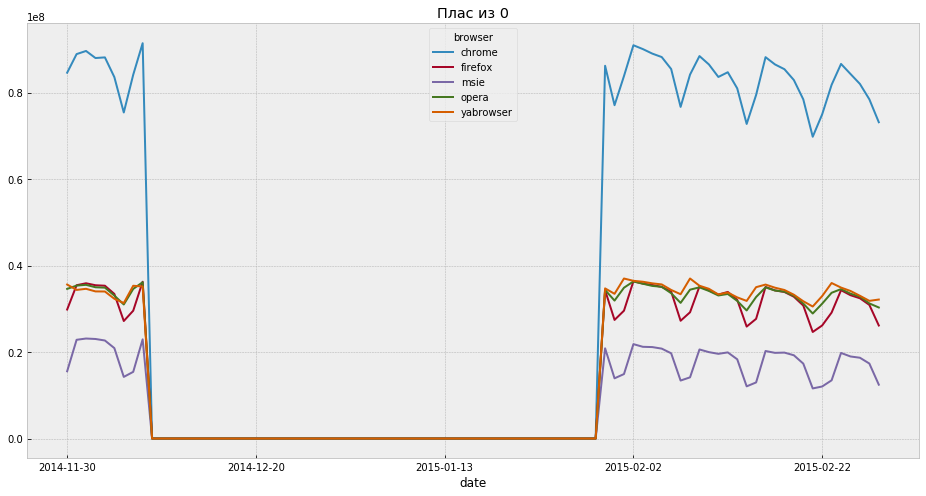

In [12]:
df[('2014-08-01' <= df.date) & (df.date <= '2014-08-30')].pivot_table(index='date', values='hits',columns='browser', aggfunc=sum).plot(title = 'Единичный выброс')
df[('2014-11-30' <= df.date) & (df.date <= '2015-02-30')].pivot_table(index='date', values='hits',columns='browser', aggfunc=sum).plot(title = 'Плас из 0')

Посмотрим сколько было дней, когда значение показателей было равно 0 (выведем для всех браузеров и se)

In [13]:
for se, browser in product(se_names, browser_names):
    data0 = full_df.loc[(full_df.se == se) & (full_df.browser == browser)]
    print(len(data0.date[data0.hits == 0]))

53
53
53
53
53
53
53
53
53
53


Посчитаем сколько точек, со значением 0, не принадлежащих плато.

In [14]:
for se, browser in product(se_names, browser_names):
    data1 = full_df.loc[(full_df.se == se) & (full_df.browser == browser)]
    row = data1.date[data1.hits == 0].index[0]
    if full_df.hits[row - 2] != 0 and full_df.hits[row + 2] != 0:
        print('one more point')
    print('another set')

one more point
another set
one more point
another set
one more point
another set
one more point
another set
one more point
another set
one more point
another set
one more point
another set
one more point
another set
one more point
another set
one more point
another set


Проверим, что 0-дни совпадают у всех браузеров, и выведем их.

In [15]:
for se, browser in product(se_names, browser_names):
    data1 = full_df.loc[(full_df.se == se) & (full_df.browser == browser)]
    row = data1.date[data1.hits == 0].index[0]
    data2 = full_df.loc[(full_df.se == se) & (full_df.browser == browser)]
    print(data2.date[data2.hits == 0])

464    2014-08-21
684    2014-12-09
686    2014-12-10
688    2014-12-11
690    2014-12-12
692    2014-12-13
694    2014-12-14
696    2014-12-15
698    2014-12-16
700    2014-12-17
702    2014-12-18
704    2014-12-19
706    2014-12-20
708    2014-12-21
710    2014-12-22
712    2014-12-23
714    2014-12-24
716    2014-12-25
718    2014-12-26
720    2014-12-27
722    2014-12-28
724    2014-12-29
726    2014-12-30
728    2014-12-31
730    2015-01-01
732    2015-01-02
734    2015-01-03
736    2015-01-04
738    2015-01-05
740    2015-01-06
742    2015-01-07
744    2015-01-08
746    2015-01-09
748    2015-01-10
750    2015-01-11
752    2015-01-12
754    2015-01-13
756    2015-01-14
758    2015-01-15
760    2015-01-16
762    2015-01-17
764    2015-01-18
766    2015-01-19
768    2015-01-20
770    2015-01-21
772    2015-01-22
774    2015-01-23
776    2015-01-24
778    2015-01-25
780    2015-01-26
782    2015-01-27
784    2015-01-28
786    2015-01-29
Name: date, dtype: object
3198    2014-08-21
3

Уберем этот единичный выброс

In [16]:
full_without_point_df = full_df.copy()
for se, browser in product(se_names, browser_names):
    data1 = full_df.loc[(full_df.se == se) & (full_df.browser == browser)]
    row = data1.date[data1.hits == 0].index[0]
    full_without_point_df.set_value(row, "hits", (full_df.hits[row - 2] + full_df.hits[row + 2])/2)       

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Также казывается, что это одно плато из 52 двух дней: '2014-12-09' - '2015-01-29'

Аналогичным способом избавися от плато, и проверим, остались ли 0-точки

In [17]:
NEXT_S = "2015-12-09"
NEXT_F = "2016-01-29"
correct_df = full_without_point_df.copy()
for se, browser in product(se_names, browser_names):
    data3 = full_without_point_df.loc[(full_without_point_df.se == se) & (full_without_point_df.browser == browser)]
    row_num = data3.date[data3.hits == 0].index.values

    row_next_year_num = data3.loc[(NEXT_F >= data3.date) & (data3.date >= NEXT_S)].index.values                
    for i, num in enumerate(row_num):
        correct_df.set_value(num, "hits", full_without_point_df.hits.loc[row_next_year_num].iloc[i] +\
                             data3.hits[data3.date == "2014-12-08"].iloc[0] - data3.hits[data3.date == "2015-12-08"].iloc[0])

    data4 = correct_df.loc[(correct_df.se == se) & (correct_df.browser == browser)]
    print(len(data4.date[data4.hits == 0]))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


0
0
0
0
0
0
0
0
0
0


Сравним получившиеся графики

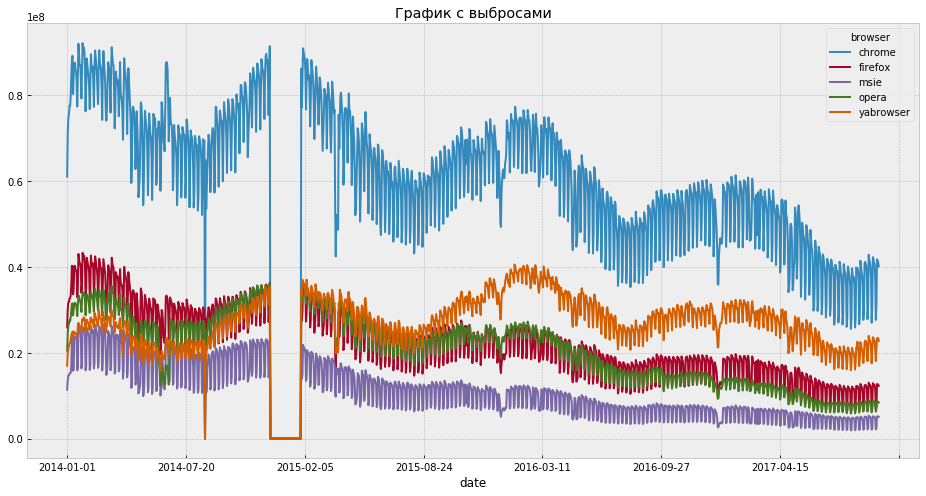

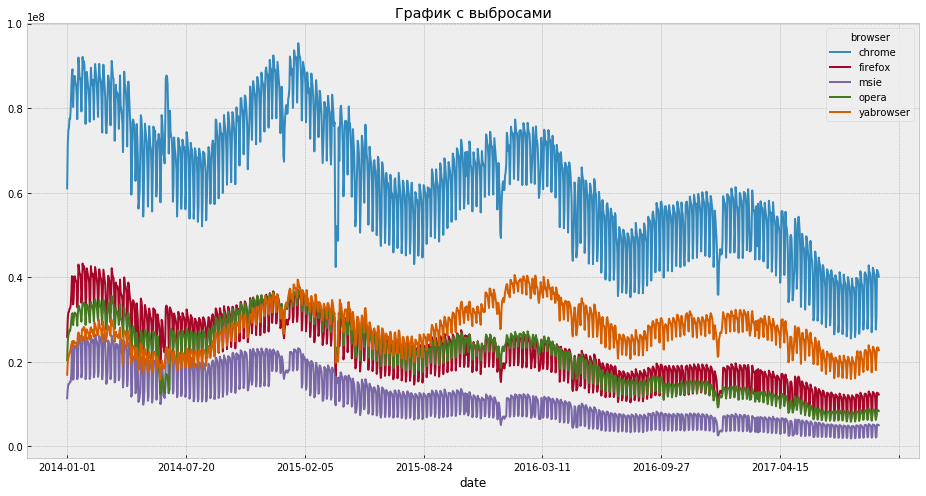

In [18]:
full_df.pivot_table(index='date', values='hits',columns='browser', aggfunc=sum).plot(title = 'График с выбросами')
correct_df.pivot_table(index='date', values='hits',columns='browser', aggfunc=sum).plot(title = 'График с выбросами')

##  Посмотрим на se

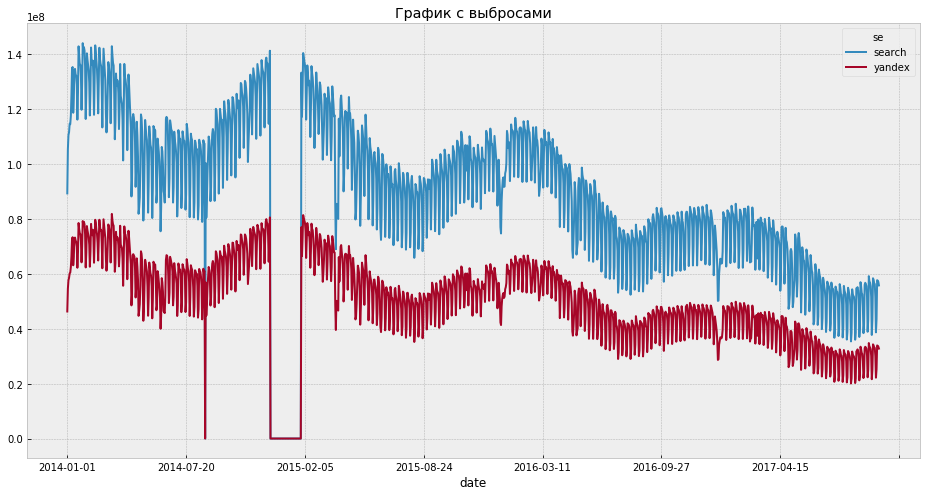

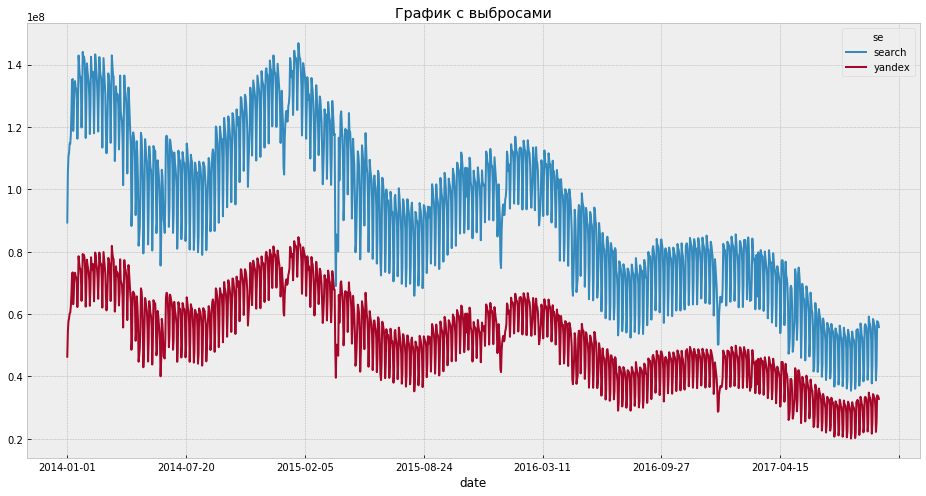

In [19]:
full_df.pivot_table(index='date', values='hits',columns='se', aggfunc=sum).plot(title = 'График с выбросами')
correct_df.pivot_table(index='date', values='hits',columns='se', aggfunc=sum).plot(title = 'График с выбросами')

Никаких ярко выраженных недостатков не видно.

#  STL

In [20]:
correct_df['hits_fixed'] = np.round(correct_df.hits)

In [24]:
new_columns = ['hits_week_trend', 'hits_week_seasonal', 'hits_year_trend', 'hits_year_seasonal']
for column in new_columns:
    correct_df[column] = np.zeros(len(correct_df))

for se, browser in product(se_names, browser_names):
    data5_ind = (correct_df.se == se) & (correct_df.browser == browser)
    data5 = correct_df.loc[(correct_df.se == se) & (correct_df.browser == browser)]
    
    ts = pd.Series(correct_df.loc[data5_ind, 'hits_fixed'].tolist(), index=correct_df.loc[data5_ind, 'date'])
    res_weakly = ts.stl(frequency=7, method='arima')
    
    trend = res_weakly.iloc[:, 1].as_matrix()
    seasonal = (res_weakly.iloc[:, 0] + res_weakly.iloc[:, 1]).as_matrix()
    correct_df.loc[data5_ind, 'hits_week_trend'] = np.round(trend)
    correct_df.loc[data5_ind, 'hits_week_seasonal'] = np.round(seasonal)
    
    ts = pd.Series(trend, index=correct_df.loc[data5_ind, 'date'])
    res_year = ts.stl(frequency=365, method='arima')
    trend = res_year.iloc[:, 1].as_matrix()
    seasonal = (res_year.iloc[:, 0] + res_year.iloc[:, 1]).as_matrix()
    correct_df.loc[data5_ind, 'hits_year_trend'] = np.round(trend)
    correct_df.loc[data5_ind, 'hits_year_seasonal'] = np.round(seasonal)

Посмотрим на недельную сезонность

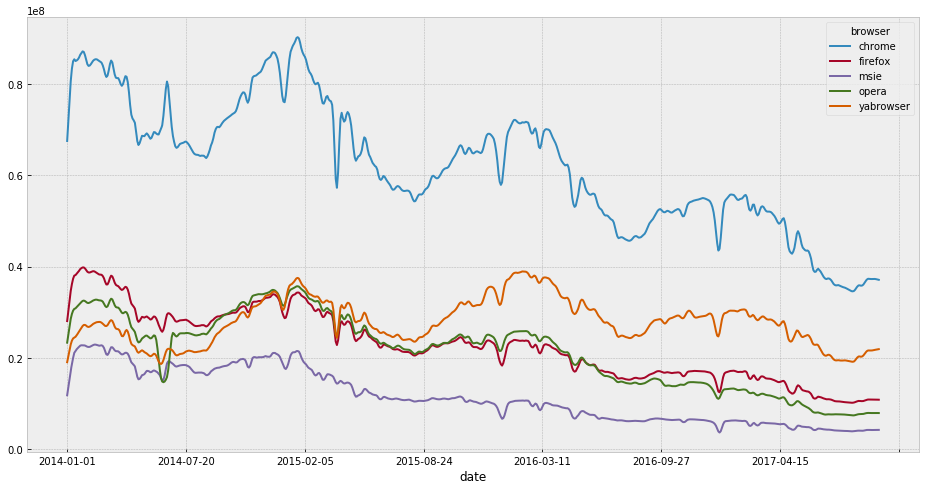

In [25]:
correct_df.pivot_table(index='date', values='hits_week_trend', columns='browser', aggfunc=np.sum).plot()

Недельную зависимость сложно оценивать

Посмотрим на годовую сезонность

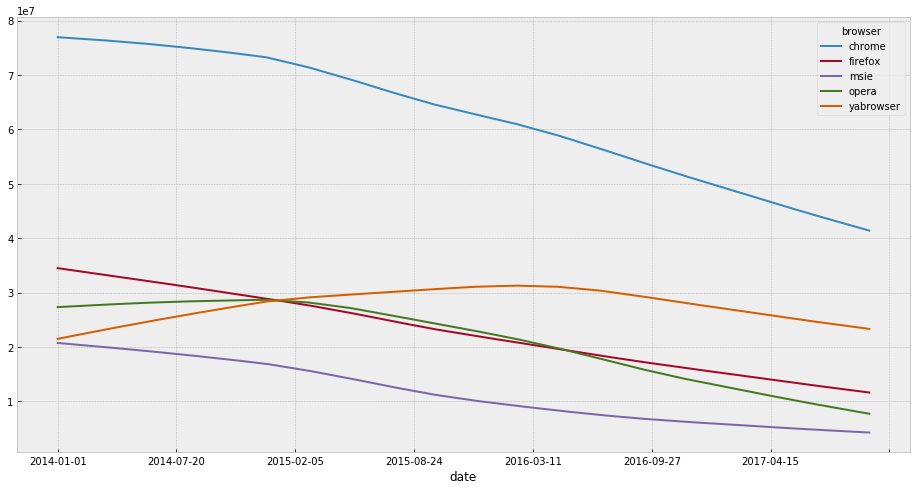

In [27]:
correct_df.pivot_table(index='date', values='hits_year_trend', columns='browser', aggfunc=np.sum).plot()

In [24]:
correct_df.to_csv('correct_data.csv', index=False)

По ней уже можно что-то сказать, перейдем к следующему заданию